In [96]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

In [97]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import scipy.integrate as spi

from tqdm import tqdm
from utils.math import get_interpolator
from utils.colors import *

DATA_FILE = "../data/clean/CUE2/dFBA.pkl"

# Load condition data
with open(DATA_FILE, "rb") as f:
    data = pickle.load(f)

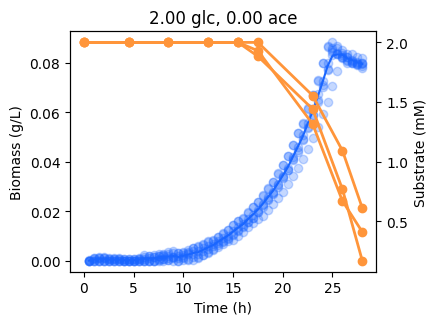

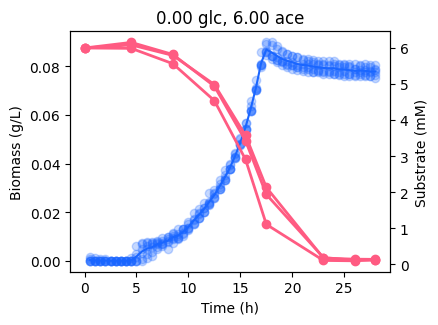

In [99]:
# To fit the uptake parameters, the plan is to:
# 1. Extract the region of data where the uptake rate is likely saturated (i.e. dN/dt ~= constant * X).
#    I assume this is true for the exponential phase of growth, so I extract that portion of the growth curve below.
# 2. Next, I fit the V_maxes by fitting the nutrient data over the exponential period. To do so, I used WolframAlpha to
#    solve dN/dt = -V_max * X(t), with X(t) = X_0 * exp(mu * t). The solution is listed below.
#    Note that using the closed-form solution does not take into account all the X(t) datapoints, so it may be slightly better
#    to use numerical integration to fit the V_maxes.
# 3. Finally, I fit the K_m's by fitting the nutrient data over the whole growth curve, fixing the V_maxes from above.

# Plot data function for use later
def plot_data(ax, t_X_obs, X_obs_replicates, t_N_obs, N_obs_replicates, lw=2, N_color = C_GLUCOSE):
    ax.plot(t_X_obs, X_obs_replicates.T, marker="o", lw=0, color=C_BIOMASS, alpha=0.25)
    ax.plot(t_X_obs, X_obs_replicates.mean(axis=0), color=C_BIOMASS)
    ax2 = ax.twinx()
    ax2.plot(t_N_obs, N_obs_replicates.T, marker="o", lw=lw, color=N_color)

    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Biomass (g/L)")
    ax2.set_ylabel("Substrate (mM)")

    return ax, ax2

# Plot data
for (g, a), dat in data.items():
    if g > 0 and a > 0:
        continue
    
    # Get raw data
    t_X_obs = dat["raw"]["raw_b_t"]
    X_obs_replicates = dat["raw"]["raw_b"]
    t_N_obs = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_t"]
    N_obs_replicates = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_s"] 

    # Plot raw data
    fig, ax = plt.subplots()
    plot_data(ax, t_X_obs, X_obs_replicates, t_N_obs, N_obs_replicates, N_color = C_GLUCOSE if g > 0 else C_ACETATE)
    ax.set_title(f"{g.magnitude:.2f} glc, {a.magnitude:.2f} ace")
    fig.tight_layout()
    fig.set_size_inches(4, 3)


/tmp/ipykernel_26495/3913222121.py:38: RuntimeWarning: invalid value encountered in divide
  dX_dt_CV = dX_dt_std / np.abs(mean_dX_dt)
/tmp/ipykernel_26495/3913222121.py:38: RuntimeWarning: divide by zero encountered in divide
  dX_dt_CV = dX_dt_std / np.abs(mean_dX_dt)


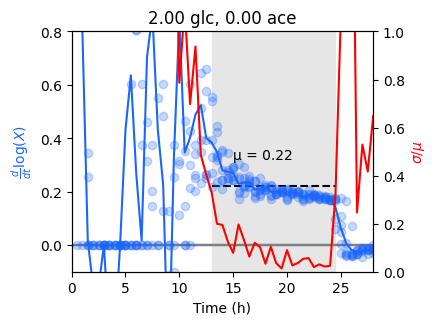

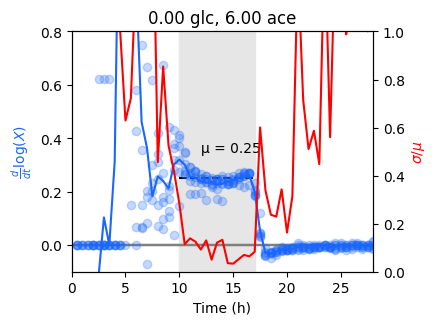

In [100]:
# To fit the uptake parameters, we first need to extract the exponential phase of growth,
# where the uptake rate is likely saturated. 
# Below, I use a method where I look for regions where the mean instantaneous growth rate is greater than a threshold,
# and the coefficient of variation (CV) of instantaneous growth rates across replicates is less than a threshold.

NO_GROWTH_THRESHOLD = 0.01
CV_THRESHOLD = 0.35

DETECTION_LIMIT = 1e-4  # Constant to add to prevent log of zero

exponential_regions = {}
growth_rates = {}
for (g, a), dat in data.items():
    if g > 0 and a > 0:
        continue

    # Get raw data, putting biomass on log-scale
    t_X_obs = dat["raw"]["raw_b_t"]
    X_obs_replicates = np.log(dat["raw"]["raw_b"] + DETECTION_LIMIT)

    # Plot dlog(X)/dt
    fig, ax = plt.subplots()
    mean_dX_dt = np.mean([np.gradient(X_obs, t_X_obs) for X_obs in X_obs_replicates], axis=0)
    for X_obs in X_obs_replicates:
        dX_dt = np.gradient(X_obs, t_X_obs)
        ax.hlines(0, 0, t_X_obs[-1], color="0.5", linestyle="-", zorder=-1)
        ax.plot(t_X_obs, dX_dt, marker="o", lw=0, color=C_BIOMASS, alpha=0.25)
    ax.plot(t_X_obs, mean_dX_dt, color=C_BIOMASS)
    ax.set_title(f"{g.magnitude:.2f} glc, {a.magnitude:.2f} ace")
    ax.set_xlim(0, t_X_obs[-1])
    ax.set_ylim(-0.1, 0.8)
    ax.set_ylabel(r"$\frac{{d}}{{dt}}\log (X)$", color=C_BIOMASS)
    ax.set_xlabel("Time (h)")

    # Get the standard deviation of the gradient
    ax2 = ax.twinx()
    dX_dt_std = np.std([np.gradient(X_obs, t_X_obs) for X_obs in X_obs_replicates], axis=0)
    dX_dt_CV = dX_dt_std / np.abs(mean_dX_dt)
    ax2.plot(t_X_obs, dX_dt_CV, color="r")
    ax2.set_ylim(0, 1)
    ax2.set_ylabel(r"$\sigma/\mu$", color="r")

    # Okay, let's say that the exponential region is where the standard deviation
    # is less than 0.05, and the gradient is greater than 0.1
    # exponential_region = (dX_dt_std < STD_THRESHOLD) & (mean_dX_dt > NO_GROWTH_THRESHOLD)
    exponential_region = (dX_dt_CV < CV_THRESHOLD) & (mean_dX_dt > NO_GROWTH_THRESHOLD)
    t_exponential = t_X_obs[exponential_region]

    # Store the exponential region
    exponential_regions[(g, a)] = exponential_region

    # Calculate the growth rate
    growth_rate = np.mean(mean_dX_dt[exponential_region])
    growth_rates[(g, a)] = growth_rate

    # Plot the exponential region
    ax.fill_between(t_X_obs, -1, 1, where=exponential_region, color="0.9", zorder=-2)
    ax.hlines(growth_rate, t_exponential[0], t_exponential[-1], color="k", linestyle="--", zorder=-1)
    ax.text(t_exponential[0] + 2, growth_rate + 0.1, f"μ = {growth_rate:.2f}", horizontalalignment="left")

    fig.tight_layout()
    fig.set_size_inches(4, 3)
        

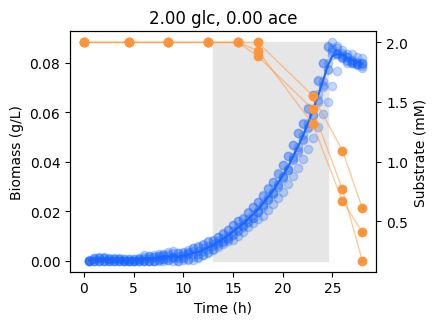

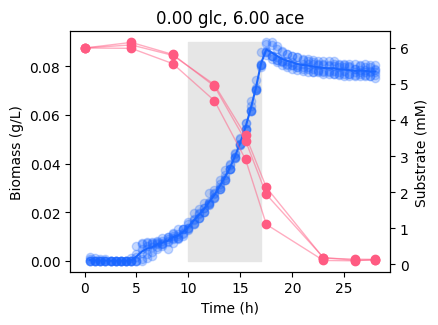

In [ ]:
# Plot the exponential regions on the raw data.
# Also, make linear interpolators for the nutrient data.

interpolated_nutrients = {}
for (g, a), dat in data.items():
    if g > 0 and a > 0:
        continue

    # Get raw data
    t_X_obs = dat["raw"]["raw_b_t"]
    X_obs_replicates = dat["raw"]["raw_b"]
    t_N_obs = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_t"]
    N_obs_replicates = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_s"]

    # Make interpolators
    N_interp = []
    for N_obs in N_obs_replicates:
        interp = get_interpolator(t_N_obs, N_obs)
        N_interp.append(interp(t_X_obs))
    N_interp = np.array(N_interp)
    interpolated_nutrients[(g, a)] = N_interp

    # Plot raw data
    fig, ax = plt.subplots()
    _, ax2 = plot_data(ax, t_X_obs, X_obs_replicates, t_N_obs, N_obs_replicates, N_color = C_GLUCOSE if g > 0 else C_ACETATE, lw=0)
    
    # Plot interpolated data
    ax2.plot(t_X_obs, N_interp.T, color=C_GLUCOSE if g > 0 else C_ACETATE, lw=1, alpha=0.5)

    # ax.set_yscale("log")
    ax.set_title(f"{g.magnitude:.2f} glc, {a.magnitude:.2f} ace")
    ax.fill_between(t_X_obs, 0, np.max(X_obs_replicates), where=exponential_regions[(g, a)], color="0.9", zorder=-2)
    fig.tight_layout()
    fig.set_size_inches(4, 3)

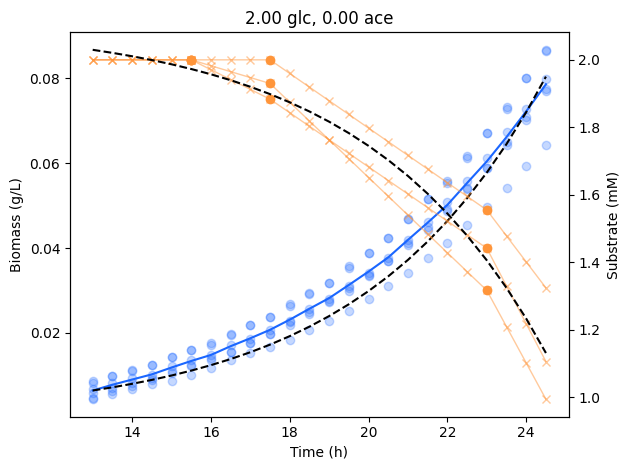

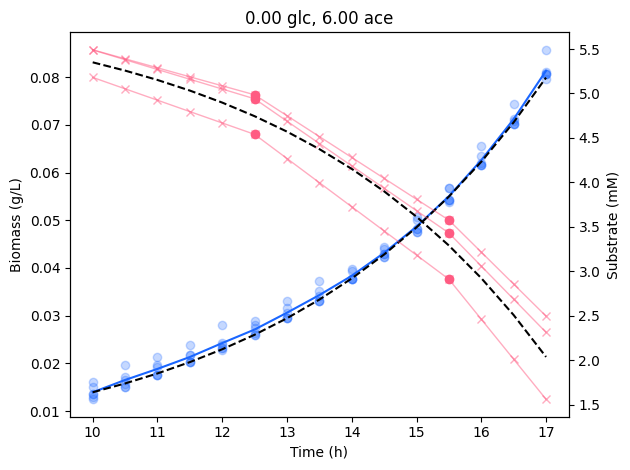

In [ ]:
# Now, we extract just the exponential region of growth, and fit a constant uptake rate
# (i.e. dN/dt = k * X) to the data. We can then use the fitted uptake rate to estimate the
# half-saturation constant.
# 
# To do the fitting, note that since we have extracted the exponential region, we know
# X(t) = X0 * exp(μ * t), and thus we can explicitly solve for N(t).
# The result is N(t) = N0 - k * X0 * (exp(μ * t) - 1) / μ.

from scipy.optimize import minimize
from scipy.integrate import odeint

def get_model_error(t, N, X0, mu):
    def model_error(N0, k):
        return np.sum((N - (N0 - k * X0 * (np.exp(mu * t) - 1) / mu))**2)
    return model_error

# Fit the model to the data
V_maxes = {}
for (g, a), dat in data.items():
    if g > 0 and a > 0:
        continue

    # Get raw data
    t_X_obs = dat["raw"]["raw_b_t"]
    X_obs_replicates = dat["raw"]["raw_b"]
    t_N_obs = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_t"]
    N_obs_replicates = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_s"]

    # Get interpolated nutrient data
    N_interp = interpolated_nutrients[(g, a)]

    # Get the exponential region
    exponential_region = exponential_regions[(g, a)]
    t_exponential = t_X_obs[exponential_region]
    X_obs_replicates = X_obs_replicates[:, exponential_region]
    t_N_exponential = t_N_obs[((t_exponential[0] < t_N_obs) & (t_N_obs < t_exponential[-1])).values]
    N_obs_replicates = N_obs_replicates[:, ((t_exponential[0] < t_N_obs) & (t_N_obs < t_exponential[-1])).values]
    N_interp = N_interp[:, exponential_region]

    # Fit the model
    X0 = X_obs_replicates.mean(axis=0)[0]
    mu = growth_rates[(g, a)]
    t_shifted = t_exponential - t_exponential[0]
    err = get_model_error(t_shifted, N_interp.mean(axis=0), X0, mu)
    sol = minimize(lambda x: err(*x), [N_interp.mean(axis=0)[0], 1])
    # err = get_model_error_integ(t_N_exponential, N_interp.mean(axis=0), X_obs_replicates.mean(axis=0))
    # sol = minimize(lambda x: err(*x), [N_interp.mean(axis=0)[0], 1])
    N0, k = sol.x
    V_maxes[(g, a)] = k

    # Plot raw data
    fig, ax = plt.subplots()
    _, ax2 = plot_data(ax, t_exponential, X_obs_replicates, t_N_exponential, N_obs_replicates, N_color = C_GLUCOSE if g > 0 else C_ACETATE, lw=0)
    ax2.plot(t_exponential, N_interp.T, color=C_GLUCOSE if g > 0 else C_ACETATE, lw=1, alpha=0.5, marker="x")
    ax.set_title(f"{g.magnitude:.2f} glc, {a.magnitude:.2f} ace")

    # Plot the model
    model_fit = N0 - k * X0 * (np.exp(mu * t_shifted) - 1) / mu
    ax.plot(t_exponential, X0 * np.exp(mu * t_shifted), color="k", linestyle="--")
    ax2.plot(t_exponential, model_fit, color="k", linestyle="--")

    fig.tight_layout()

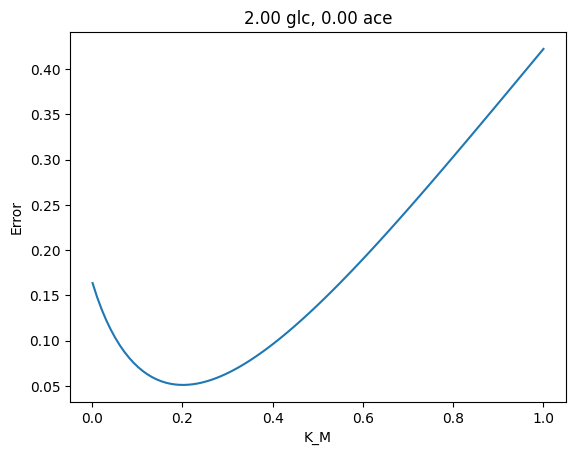

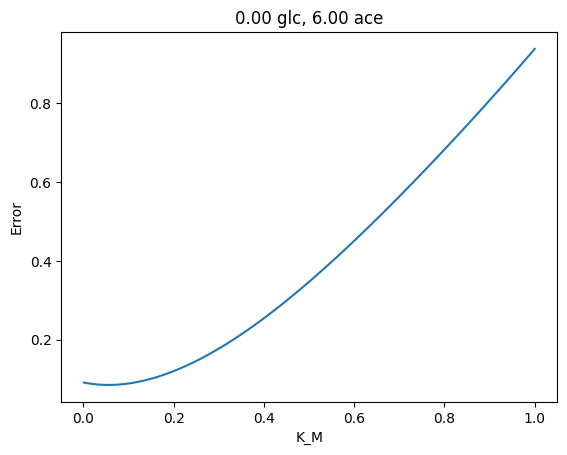

In [105]:
# Before running the final fitting, we plot the error as a function of K_M
# to make sure the fitting works properly.
for (g, a), dat in data.items():
    if (g, a) not in V_maxes:
        continue

    # Get raw data
    t_X_obs = dat["raw"]["raw_b_t"]
    X_obs_replicates = dat["raw"]["raw_b"]
    t_N_obs = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_t"]
    N_obs_replicates = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_s"]

    # Take mean of X
    X_obs_mean = X_obs_replicates.mean(axis=0)

    # Get stored V_max (treated as constant)
    V_max = V_maxes[(g, a)]

    # Define derivative
    def michaelis_menten(N, t, K_M, X=X_obs_mean, t_X_obs=t_X_obs):
        # equations
        X_t = np.interp(t, t_X_obs, X)
        return -V_max * (N / (K_M + N)) * X_t
    
    # Define error function
    def error(log_K_M):
        K_M = np.exp(log_K_M)
        N_model = spi.odeint(michaelis_menten, N_obs_replicates.mean(axis=0)[0], t_N_obs, args=(K_M,)).flat
        # TODO: don't average before taking error?
        return np.sum((N_obs_replicates.mean(axis=0) - N_model)**2)
    
    K_Ms = np.linspace(0.001, 1, 100)
    log_K_Ms = np.log(K_Ms)
    errors = np.array([error(log_K_M) for log_K_M in log_K_Ms])

    fig, ax = plt.subplots()
    ax.plot(K_Ms, errors)
    ax.set_xlabel("K_M")
    ax.set_ylabel("Error")
    ax.set_title(f"{g.magnitude:.2f} glc, {a.magnitude:.2f} ace")
    # ax.set_xscale("log")

Optimization terminated successfully.
         Current function value: 0.051125
         Iterations: 17
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 0.084568
         Iterations: 15
         Function evaluations: 33


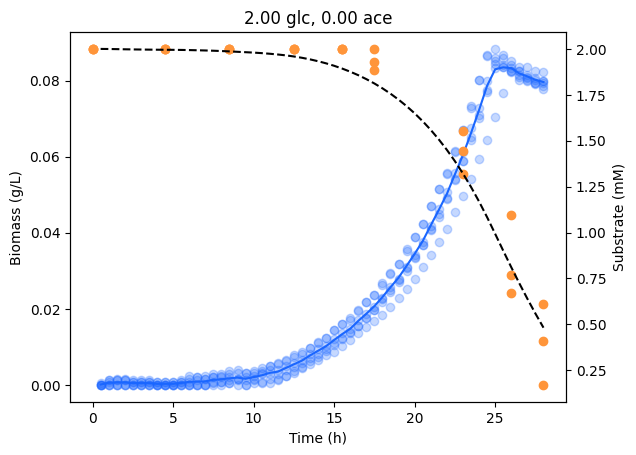

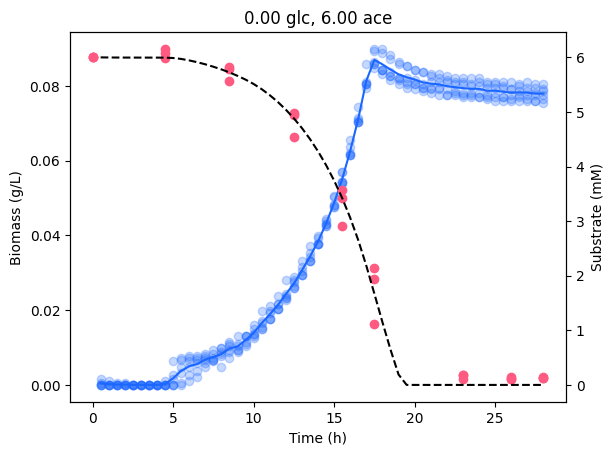

In [ ]:
# Now, we can fit the K_M's for fixed V_max.

from scipy.optimize import fmin

K_Ms = {}
for (g, a), dat in data.items():
    if (g, a) not in V_maxes:
        continue
    
    # Get raw data
    t_X_obs = dat["raw"]["raw_b_t"]
    X_obs_replicates = dat["raw"]["raw_b"]
    t_N_obs = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_t"]
    N_obs_replicates = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_s"]

    # Take mean of X
    X_obs_mean = X_obs_replicates.mean(axis=0)

    # Get stored V_max (treated as constant)
    V_max = V_maxes[(g, a)]

    # Define derivative
    def michaelis_menten(N, t, K_M, X=X_obs_mean, t_X_obs=t_X_obs):
        # equations
        X_t = np.interp(t, t_X_obs, X)
        return -V_max * (N / (K_M + N)) * X_t
    
    # Define error function
    def error(log_K_M):
        K_M = np.exp(log_K_M)
        N_model = spi.odeint(michaelis_menten, N_obs_replicates.mean(axis=0)[0], t_N_obs, args=(K_M,)).flat
        # TODO: don't average before taking error?
        return np.sum((N_obs_replicates.mean(axis=0) - N_model)**2)

    # Fit the model
    # sol = minimize(error, [np.log(1)])
    log_K_M = fmin(error, np.log(0.1))
    K_M = np.exp(log_K_M)
    K_Ms[(g, a)] = K_M
    # K_M = 0.1

    # Plot raw data
    fig, ax = plt.subplots()
    _, ax2 = plot_data(ax, t_X_obs, X_obs_replicates, t_N_obs, N_obs_replicates, N_color = C_GLUCOSE if g > 0 else C_ACETATE, lw=0)
    ax.set_title(f"{g.magnitude:.2f} glc, {a.magnitude:.2f} ace")

    # Plot the model
    N_model = spi.odeint(michaelis_menten, N_obs_replicates.mean(axis=0)[0], t_X_obs, args=(K_M,))
    ax2.plot(t_X_obs, N_model, color="k", linestyle="--")

In [95]:
K_Ms

{(<Quantity(2.0, 'millimolar')>,
  <Quantity(0.0, 'millimolar')>): array([0.20110273]),
 (<Quantity(0.0, 'millimolar')>,
  <Quantity(6.0, 'millimolar')>): array([0.05545247])}